# Classification using Pytorch and Torchtext

Why CNN? Why noy LSTM?
- LSTM treats words as a sequence: I --> love --> sushi
    - LSTM is just basically linear layers but a loop
- CNN treats words as a n-grams: "I love", "love sushi"
    - CNN is just basically linear layers + window

For example :

Chaky is making a sentiment analysis models.

You can prepare a bigram window - CNN filter size of (height, width) ==> (1,2)

Chaky is
is making
making a
a sentiment
etc.

You can also play with stride....... e.g., stride = 2

Chaky is
making a 

You can also play with padding ...., eg., padding = 2

padding Chaky
Chaky is
.....
models padding

Next big thing is very cool.... i.e., so which width we should use
e.g., bi-gram(2), tri-grams(3), ??

Answer: use all , 100 filters, 1 for uni-gram, 1-bigram

Next thing - can CNN handles long-term relationships?

Answer: yes!! by stacking more layers of CNN

Chaky is 
making a

In [1]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
torchtext.__version__

'0.14.1'

## 1. ETL: Loading the dataset

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [8]:
#let's change the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

{1, 2, 3, 4}

In [9]:
train_size = len(list(iter(train)))
train_size

120000

Since 120000 gonna just take up too much of our GPU, and also for the sake of learning, we gonna resize it.....  All `DataPipe` instance has a handy function called `random_split`

In [10]:
too_much, train, valid = train.random_split(total_length=train_size, weights = {"too_much": 0.7, "smaller_train": 0.2, "valid": 0.1}, seed=999)

In [11]:
train_size = len(list(iter(train)))
train_size

24000

In [12]:
val_size = len(list(iter(valid)))
val_size

12000

In [13]:
test_size = len(list(iter(test)))
test_size

7600

## 3. Preprocessing 

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [14]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

### Text to integers (numeral)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [15]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [16]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[509, 27, 9, 0, 9]

In [17]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'here'

In [18]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [19]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [20]:
#so we can 50k+ unique vocabularies!
len(vocab)

52828

## 4. FastText Embeddings

In [21]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [22]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [23]:
fast_embedding.shape   #we have X vocabs, each with a 300 fasttext embedding

torch.Size([52828, 300])

## 4. Preparing the dataloader

In torchtext, first thing before the batch iterator is to define how you want to process your text and label.  

In [24]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

Let's look at example how it looks

In [25]:
text_pipeline("I love to play football")

[275, 4021, 8, 389, 574]

In [26]:
label_pipeline('1')

0

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.  **Since we are using CNN, we don't need the lengths which are needed for LSTM when we use pad_packed_sequence**.

In [27]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

Create train, val, and test dataloaders

In [28]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.  Note that {“World”, “Sports”, “Business”, “Sci/Tech”} maps to {0, 1, 2, 3}

In [29]:
for label, text in train_loader:
    break

In [30]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 138])


## 5. Design the model

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. 

Consider the 2 dimensional representation of the embedded sentence below:

<img src = "../figures/sentiment9.png">

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. 

Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a **[4x5]** "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. 

The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

<img src = "../figures/sentiment12_2.png" width=500>

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated. 

<img src = "../figures/sentiment13.png">

Finally, the filter moves down again and the final output for this filter is calculated.

<img src = "../figures/sentiment14.png">

In our case , our output will be a vector with number of elements equal to the height of the image (or length of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for classification.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

<img src = "../figures/sentiment15.png">

The idea here is that the maximum value is the "most important" feature for prediction, which corresponds to the "most important" n-gram within the text. How do we know what the "most important" n-gram is? Luckily, we don't have to! Through backpropagation, the weights of the filters are changed so that whenever certain n-grams that are highly indicative of the labels, the output of the filter is a "high" value. This "high" value then passes through the max pooling layer if it is the maximum value in the output. 

Note: Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters.

As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 300 n-grams and making a final decision. 

### Implementation Details

We implement the convolutional layers with `nn.Conv2d`. The `in_channels` argument is the number of "channels" in your image going into the convolutional layer. In actual images this is usually 3 (one channel for each of the red, blue and green channels), however when using text we only have a single channel, the text itself. The `out_channels` is the number of filters and the `kernel_size` is the size of the filters. Each of our `kernel_size`s is going to be **[n x emb_dim]** where $n$ is the size of the n-grams.

The second dimension of the input into a `nn.Conv2d` layer must be the channel dimension. As text technically does not have a channel dimension, we `unsqueeze` our tensor to create one. This matches with our `in_channels=1` in the initialization of our convolutional layers. 

We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In our dataset there are no text smaller than 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

# batch_samples_RNN = (batch_size, seq_len, emb_dim)
# batch_samples_CNN = (batch_size, 1, seq_len, emb_dim)

class CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.conv3 = nn.Conv2d(
                        in_channels  = 1,
                        out_channels = n_filters, #100
                        kernel_size  = (3, emb_dim) #tri-grams
                        )
        self.conv4 = nn.Conv2d(
                        in_channels  = 1,
                        out_channels = n_filters, #100
                        kernel_size  = (4, emb_dim) #quad-grams
                        )
        self.conv5 = nn.Conv2d(
                        in_channels  = 1,
                        out_channels = n_filters, #100
                        kernel_size  = (5, emb_dim) #penta-grams
                        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * 3, output_dim)

    def forward(self, text): 
        #text : [batch_size, seq_len]
                
        #embed the text
        embedded = self.embedding(text)
        #embedded : [batch_size, seq_len, emb_dim]
        #reshape embedded into [batch_size, 1, seq_len, emb_dim] for CNN
        embedded = embedded.unsqueeze(1)
        #embedded : [batch_size, 1, seq_len, emb_dim]

        #pass through conv2d
        conv_fea3 = self.conv3(embedded) #conv_fea3: [batch_size, out_channels, seq_len*, 1]
        conv_fea4 = self.conv4(embedded) #conv_fea4: [batch_size, out_channels, seq_len*, 1]
        conv_fea5 = self.conv5(embedded) #conv_fea5: [batch_size, out_channels, seq_len*, 1]

        #squeeze the last dimension
        #because maxpool1d expects only 3d tensors, not 4d
        conv_fea3 = conv_fea3.squeeze(3) #conv_fea3: [batch_size, out_channels, seq_len*]
        conv_fea4 = conv_fea4.squeeze(3) #conv_fea4: [batch_size, out_channels, seq_len*]
        conv_fea5 = conv_fea5.squeeze(3) #conv_fea5: [batch_size, out_channels, seq_len*]

        #activation.....
        conv_fea3 = F.relu(conv_fea3) #F is not learnable
        conv_fea4 = F.relu(conv_fea4)
        conv_fea5 = F.relu(conv_fea5)

        #maxpooling - to find the most important words in that grams...
        conv_fea3_max = F.max_pool1d(conv_fea3, conv_fea3.shape[2]) #conv_fea3_max: [batch_size, out_channels, 1]
        conv_fea4_max = F.max_pool1d(conv_fea4, conv_fea4.shape[2]) #conv_fea4_max: [batch_size, out_channels, 1]
        conv_fea5_max = F.max_pool1d(conv_fea5, conv_fea5.shape[2]) #conv_fea5_max: [batch_size, out_channels, 1]

        #We are ready to put it into the linear layers!!!!
        #1. since linear layer only takes 2d input, we can squeeze
        conv_fea3_max = conv_fea3_max.squeeze(2) #conv_fea3_max: [batch_size, out_channels]
        conv_fea4_max = conv_fea4_max.squeeze(2) #conv_fea4_max: [batch_size, out_channels]
        conv_fea5_max = conv_fea5_max.squeeze(2) #conv_fea5_max: [batch_size, out_channels]
        #2. concat all three features into one
        final_conv_max = torch.cat((conv_fea3_max,conv_fea4_max,conv_fea5_max), dim=1)
        #final_conv_max : [batch_size, out_channels * n_filters]
        #3. dropout
        final_conv_max = self.dropout(final_conv_max)

        return self.fc(final_conv_max)

### Let's try whether the model works

In [32]:
nput_dim = len(vocab)
emb_dim = 300 #fasttext
output_dim = 4 #four news
dropout = 0.5
n_filters = 100 
model = CNN(nput_dim, emb_dim, output_dim, dropout, n_filters)

In [33]:
batch_size = 3
seq_len = 50

text = torch.randint(0,1,(batch_size, seq_len))

out = model(text)

In [34]:
out.shape #[batch_size, output_dim]

torch.Size([3, 4])

In [35]:
out

tensor([[-0.3143, -0.3324,  0.0093,  0.2794],
        [-0.2000, -0.0984,  0.1472,  0.1123],
        [ 0.1003,  0.0632,  0.1125,  0.0579]], grad_fn=<AddmmBackward0>)

Currently the `CNN` model can only use 3 different sized filters, but we can actually improve the code of our model to make it more generic and take any number of filters.

We do this by placing all of our convolutional layers in a  `nn.ModuleList`, a function used to hold a list of PyTorch `nn.Module`s. If we simply used a standard Python list, the modules within the list cannot be "seen" by any modules outside the list which will cause us some errors.

We can now pass an arbitrary sized list of filter sizes and the list comprehension will create a convolutional layer for each of them. Then, in the `forward` method we iterate through the list applying each convolutional layer to get a list of convolutional outputs, which we also feed through the max pooling in a list comprehension before concatenating together and passing through the dropout and linear layers.

In [36]:
import torch.nn as nn
import torch.nn.functional as F

# batch_samples_RNN = (batch_size, seq_len, emb_dim)
# batch_samples_CNN = (batch_size, 1, seq_len, emb_dim)

class CNN(nn.Module):  #more elegant version
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters,filter_sizes):

        #filter_sizes = [3,4,5]
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.conv = nn.ModuleList([
                        nn.Conv2d(
                            in_channels  = 1,
                            out_channels = n_filters, #100
                            kernel_size  = (fs, emb_dim) #tri-grams
                            )
                        for fs in filter_sizes
                    ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), output_dim)

    def forward(self, text): 
        #text : [batch_size, seq_len]
                
        #embed the text
        embedded = self.embedding(text)
        #embedded : [batch_size, seq_len, emb_dim]
        #reshape embedded into [batch_size, 1, seq_len, emb_dim] for CNN
        embedded = embedded.unsqueeze(1)
        #embedded : [batch_size, 1, seq_len, emb_dim]

        conv_fea = [F.relu(conv(embedded)).squeeze(3) for conv in self.conv]

        conv_fea_max = [F.max_pool1d(each_conv_fea, each_conv_fea.shape[2]).squeeze(2) for each_conv_fea in conv_fea]

        #2. concat all three features into one
        #3. dropout
        final_conv_max = self.dropout(torch.cat(conv_fea_max, dim=1))
        #final_conv_max : [batch_size, out_channels * n_filters]

        return self.fc(final_conv_max)

### Let's try whether the model works

In [37]:
nput_dim = len(vocab)
emb_dim = 300 #fasttext
output_dim = 4 #four news
dropout = 0.5
n_filters = 100 
filter_sizes = [3,4,5]
model = CNN(nput_dim, emb_dim, output_dim, dropout, n_filters,filter_sizes)

In [38]:
batch_size = 3
seq_len = 50

text = torch.randint(0,1,(batch_size, seq_len))

out = model(text)

In [39]:
out.shape #[batch_size, output_dim]

torch.Size([3, 4])

In [40]:
out

tensor([[-0.4441, -0.3789,  0.0064,  0.1075],
        [-0.4537, -0.3498, -0.6861,  0.0339],
        [-0.8129,  0.2903, -0.3490,  0.2462]], grad_fn=<AddmmBackward0>)

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

<img src = "../figures/conv1d.png">

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested. 

In [41]:
import torch.nn as nn
import torch.nn.functional as F

# batch_samples_RNN = (batch_size, seq_len, emb_dim)
# batch_samples_CNN = (batch_size, 1, seq_len, emb_dim)

class CNN1d(nn.Module): 
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters,filter_sizes):

        #filter_sizes = [3,4,5]
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.conv = nn.ModuleList([
                        nn.Conv1d(
                            in_channels  = emb_dim,
                            out_channels = n_filters, #100
                            kernel_size  = fs #n-grams
                            )
                        for fs in filter_sizes
                    ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), output_dim)

    def forward(self, text): 
        #text : [batch_size, seq_len]
                
        #embed the text
        embedded = self.embedding(text)
        #embedded : [batch_size, seq_len, emb_dim]
        #reshape embedded into [batch_size, emb_dim, seq_len] for CNN1d
        embedded = embedded.permute(0,2,1)
        #embedded : [batch_size, emb_dim, seq_len]

        conv_fea = [F.relu(conv(embedded)) for conv in self.conv]
        #conv_fea : [batch_size, emb_dim, seq_len]

        conv_fea_max = [F.max_pool1d(each_conv_fea, each_conv_fea.shape[2]).squeeze(2) for each_conv_fea in conv_fea]
        #pooled_n = [batch size, n_filters]

        #2. concat all three features into one
        #3. dropout
        final_conv_max = self.dropout(torch.cat(conv_fea_max, dim=1))
        #final_conv_max : [batch_size, out_channels * n_filters]

        return self.fc(final_conv_max)

### Let's try whether the model works

In [42]:
nput_dim = len(vocab)
emb_dim = 300 #fasttext
output_dim = 4 #four news
dropout = 0.5
n_filters = 100 
filter_sizes = [3,4,5]
model = CNN1d(nput_dim, emb_dim, output_dim, dropout, n_filters,filter_sizes)

In [43]:
batch_size = 3
seq_len = 50

text = torch.randint(0,1,(batch_size, seq_len))

out = model(text)

In [44]:
out.shape #[batch_size, output_dim]

torch.Size([3, 4])

In [45]:
out

tensor([[ 0.4197, -0.1610,  0.6678,  0.5731],
        [ 0.3508, -0.0159,  1.1033, -0.0501],
        [ 0.5514, -0.0226,  0.3623,  0.1382]], grad_fn=<AddmmBackward0>)

## 6. Training

In [46]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [47]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w)

tensor([[ 0.2172, -0.0430, -0.4386,  0.7899, -0.6304],
        [-0.3978,  0.4094, -0.0527, -1.1432, -0.5326],
        [-0.4837,  0.1250, -0.3675,  0.1728,  0.4726]])

In [48]:
input_dim  = len(vocab)
emb_dim    = 300
output_dim = 4 #four classes

#for cnn
dropout = 0.5
n_filters = 100
filter_sizes = [3, 4, 5]

model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [49]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

15848400
 90000
   100
120000
   100
150000
   100
  1200
     4
______
16209904


As you can see, a lot of the complexity resides in the embedding layer.  In the future, we shall use some pretrained embeddings to fix this complexity.

In [50]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [51]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [52]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [53]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Putting everything together

In [54]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [55]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
best_valid_loss = float('inf')
num_epochs      = 10

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 7m 11s
	Train Loss: 1.481 | Train Acc: 30.80%
	 Val. Loss: 1.260 |  Val. Acc: 50.80%
Epoch: 02 | Time: 7m 22s
	Train Loss: 1.419 | Train Acc: 33.20%
	 Val. Loss: 1.215 |  Val. Acc: 59.54%
Epoch: 03 | Time: 7m 14s
	Train Loss: 1.359 | Train Acc: 36.79%
	 Val. Loss: 1.170 |  Val. Acc: 64.99%
Epoch: 04 | Time: 7m 20s
	Train Loss: 1.307 | Train Acc: 39.56%
	 Val. Loss: 1.138 |  Val. Acc: 67.84%
Epoch: 05 | Time: 7m 24s
	Train Loss: 1.267 | Train Acc: 42.00%
	 Val. Loss: 1.097 |  Val. Acc: 71.08%
Epoch: 06 | Time: 7m 18s
	Train Loss: 1.221 | Train Acc: 45.57%
	 Val. Loss: 1.061 |  Val. Acc: 72.58%
Epoch: 07 | Time: 7m 18s
	Train Loss: 1.181 | Train Acc: 47.92%
	 Val. Loss: 1.028 |  Val. Acc: 74.29%
Epoch: 08 | Time: 7m 27s
	Train Loss: 1.145 | Train Acc: 50.24%
	 Val. Loss: 0.999 |  Val. Acc: 75.70%
Epoch: 09 | Time: 7m 21s
	Train Loss: 1.108 | Train Acc: 53.12%
	 Val. Loss: 0.963 |  Val. Acc: 76.79%
Epoch: 10 | Time: 7m 17s
	Train Loss: 1.079 | Train Acc: 55.03%
	 Val. Lo

Text(0, 0.5, 'loss')

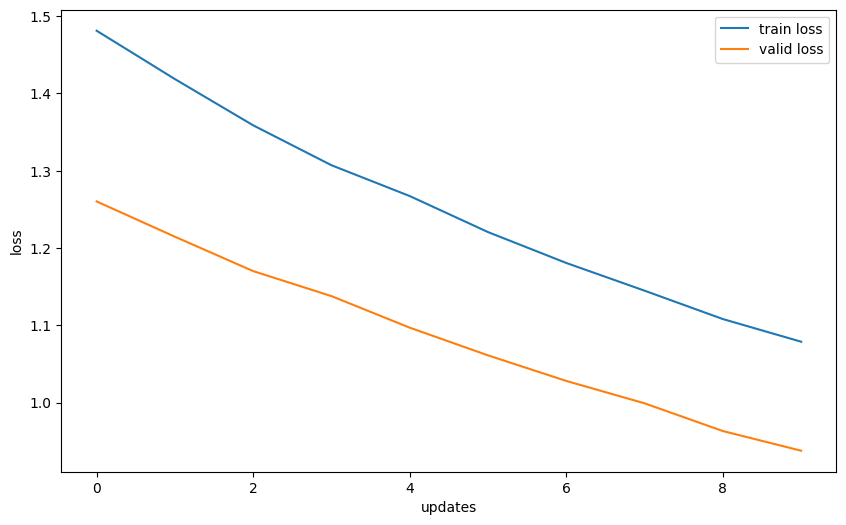

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

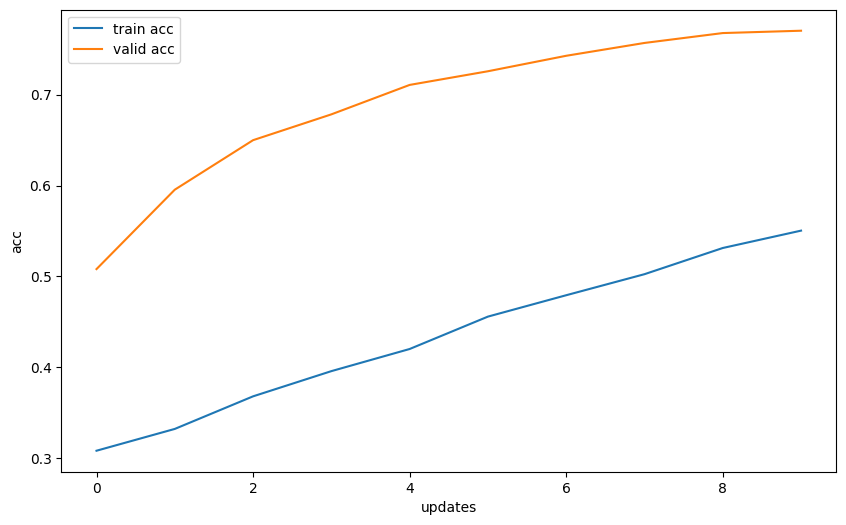

In [60]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [61]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.946 | Test Acc: 76.45%


## 7. Test on some random news

In [62]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  190,    27,   231,  1742, 14918,     6,    16,    21,   358,    27,
         2561,  1316,   231,     6], device='cuda:0')

In [63]:
text_list = [x.item() for x in text]
text_list

[190, 27, 231, 1742, 14918, 6, 16, 21, 358, 27, 2561, 1316, 231, 6]

In [64]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [65]:
text = text.reshape(1, -1)  #because batch_size is 1

In [66]:
text.shape

torch.Size([1, 14])

In [67]:
def predict(text):
    with torch.no_grad():
        output = model(text).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [68]:
predict(text) #0,1,2 = Techonology, 3

tensor([2], device='cuda:0')